In [1]:
import numpy as np
import bilby 
import pycbc 
import sys
import matplotlib.pyplot as plt
import pandas as pd
from glasflow import RealNVP, CouplingNSF

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

import pickle
import os
import json
import glob



<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/qian.hu/.conda/envs/myigwn-py39/lib/python3.9/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [2]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
#from .utils import PARAMETER_NAMES_ALL_PRECESSINGBNS_BILBY
from river.models.utils import *
from river.data.utils import *

import river.data
from river.data.datagenerator import DataGeneratorBilbyFD
from river.data.dataset import DatasetSVDStrainFDFromSVDWFonGPU, DatasetSVDStrainFDFromSVDWFonGPUBatch
from river.data.dataset import DatasetConvStrainFDFromSVDWFonGPU, DatasetConvStrainFDFromSVDWFonGPUBatch
#import river.data.utils as datautils
from river.data.utils import *
from river.data.reparameterize import *

from river.models import embedding
from river.models.utils import *
#from river.models.embedding.pca import project_strain_data_FDAPhi
from river.models.embedding.conv import EmbeddingConv1D, EmbeddingConv2D
from river.models.embedding.mlp import EmbeddingMLP1D
from river.models.inference.cnf import GlasflowEmbdding

# Make test data

In [3]:
source_type = 'BNS'
detector_names = ['H1', 'L1', 'V1'] 
duration = 32
f_low = 50
f_high = 1024

f_ref = 20
sampling_frequency = 2048
waveform_approximant = 'IMRPhenomPv2_NRTidal'
parameter_names = PARAMETER_NAMES_ALL_PRECESSINGBNS_BILBY
PSD_type = 'bilby_default' #'zero_noise' bilby_default
use_sealgw_detector = True

Vhfile="/home/qian.hu/mlpe/river/test/outputs/Vh_50Hz1024Hz32s.pickle"

data_generator = DataGeneratorBilbyFD(source_type,
            detector_names, 
            duration, 
            f_low, 
            f_ref, 
            sampling_frequency, 
            waveform_approximant, 
            parameter_names,
            PSD_type=PSD_type,
            use_sealgw_detector=use_sealgw_detector,
            f_high=f_high)

19:40 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using bilby_default PSDs to generate data.


In [39]:
validfolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin_lb/valid'
trainfolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin_lb/train'
#noisefolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin/noise/design'

valid_filenames = glob.glob(f"{validfolder}/batch*/*.h5")
train_filenames = glob.glob(f"{trainfolder}/batch*/*.h5")

add_noise = True
do_reparameterize = True
fix_extrinsic = False

#dataset_valid = DatasetSVDStrainFDFromSVDWFonGPU(valid_filenames, PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
#                                     Nbasis=512, Vhfile=Vhfile, fix_extrinsic=True, add_noise=add_noise,reparameterize=do_reparameterize)
dataset_valid = DatasetConvStrainFDFromSVDWFonGPU(valid_filenames, PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
                                     Nbasis=512, Vhfile=Vhfile, fix_extrinsic=fix_extrinsic, add_noise=add_noise,reparameterize=do_reparameterize)

#dataset_train = DatasetSVDStrainFDFromSVDWFonGPU(train_filenames[:1], PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
#                                     Nbasis=512, Vhfile=Vhfile, fix_extrinsic=True)

#dataset_train = DatasetSVDStrainFDFromSVDWFonGPUBatch(train_filenames[:1], PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
#                                     Nbasis=512, Vhfile=Vhfile, fix_extrinsic=True, add_noise=add_noise,reparameterize=do_reparameterize)



In [5]:
detector_names = config_datagenerator['detector_names']

Ntest = 2
injection_parameters_test = generate_BNS_injection_parameters(Nsample = 2*Ntest, **config_datagenerator)
data_generator_test = DataGeneratorBilbyFD(**config_datagenerator)


00:54 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using bilby_default PSDs to generate data.


In [6]:
data_generator_test.inject_signals(injection_parameters_test, 2*Ntest, Ntest)
data_generator_test.numpy_starins()

Injecting 0-th signal, 0.0% done
Injecting 1-th signal, 25.0% done


In [7]:
data_generator_test.data['strains']['H1'].shape

(2, 321281)

In [8]:
x = project_data(data_generator_test, ipca_gen, detector_names)

data_dict = {}
data_dict['x'] = x.numpy()
data_dict['injection_parameters'] = data_generator_test.data['injection_parameters']



In [26]:
dataset_test = DatasetXFromPreCalSVDData(precaldata_list=[data_dict],  parameter_names=config_datagenerator['context_parameter_names'])


def read_in_x(filename_list, Nsample=1e20):
    x_list = []
    for filename in filename_list:
        if len(x_list)*200>Nsample:
            break
        x_list.append(load_dict_from_hdf5(filename))
    return x_list

valid_precaldata_filelist = glob.glob(f"{config['precaldata_parameters']['valid']['folder']}/batch*/*.h5")
valid_precaldata_list = read_in_x(valid_precaldata_filelist, Nsample=3)
dataset_valid = DatasetXFromPreCalSVDData(precaldata_list=valid_precaldata_list,  parameter_names=config_datagenerator['context_parameter_names'])



In [9]:
len(dataset_test)

2

In [10]:
#batch_size = 1
#test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

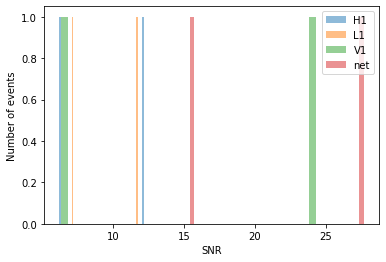

In [9]:

for key, values in data_generator_test.data['SNRs'].items():
    _ = plt.hist(values, label=key, alpha=0.5, bins=40)
_ = plt.hist((data_generator_test.data['SNRs']['H1']**2 + data_generator_test.data['SNRs']['L1']**2 + data_generator_test.data['SNRs']['V1']**2 )**0.5,
                label='net', alpha=0.5, bins=40)
plt.legend()
plt.xlabel('SNR')
plt.ylabel('Number of events')
plt.show()

In [10]:
(data_generator_test.data['SNRs']['H1']**2 + data_generator_test.data['SNRs']['L1']**2 + data_generator_test.data['SNRs']['V1']**2 )**0.5

array([15.39624868, 27.69616012])

# Load model

In [32]:
config_path = '/home/qian.hu/mlpe/river/scripts/trained_models/BNS50102432_ConvRealImag_Conv1D_8M_17D'
#config_path = '/home/qian.hu/mlpe/river/scripts/trained_models/BNS50102432_RealImag_Conv1D_8M_12D_nn'
with open(f"{config_path}/config.json", 'r') as f:
        config_dict = json.load(f)

device='cuda'
model = GlasflowEmbdding(config_dict).to(device)


Initialized MLP in channel: 1648


In [33]:
ckpt_dir = config_dict['ckpt_dir']
ckpt_path = f'{ckpt_dir}/checkpoint.pickle'

In [34]:

checkpoint = torch.load(ckpt_path, map_location=device)
start_epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['model_state_dict']) 

print(f'Loaded states from {ckpt_path}, epoch={start_epoch}.')

Loaded states from trained_models/BNS50102432_ConvRealImag_Conv1D_8M_17D/checkpoint.pickle, epoch=7.


In [35]:
def mysample_GlasNSFWarpper(model, dataset, parameter_names=None, device='cpu', Nsample=5000, max_event=1e3):
    model.eval()
    loss_list = []
    sample_list = []
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    injection_parameters_list = []
    with torch.no_grad():
        i = 0
        for theta, x in dataloader:
            theta = theta.to(device)
            x = x.to(device)
            
            if type(dataset) in [DatasetSVDStrainFDFromSVDWFonGPUBatch, DatasetConvStrainFDFromSVDWFonGPUBatch]:
                #print('w3')
                theta = theta.view(dataset.minibatch_size, theta.shape[-1])
                x = x.view(dataset.minibatch_size, x.shape[-2], x.shape[-1])
            
            
            lenx = x.shape[-1]
            lentheta = theta.shape[-1]
            loss = -model.log_prob(theta, x=x).mean()
            samples = model.sample(Nsample, x=x)
            
            inj_para = {}
            for j, paraname in enumerate(parameter_names):
                inj_para[paraname] = inverse_reparameterize(theta[0][j].cpu().numpy(), paraname)
                
            loss_list.append(loss.detach().cpu())
            sample_list.append(samples.cpu().numpy())
            injection_parameters_list.append(inj_para)
            i+=1
            if i>=max_event:
                break
            
    samples = np.array(sample_list)
    samples = torch.from_numpy(samples)

    return samples.movedim(1,2), loss_list, injection_parameters_list


In [40]:
#parameter_names = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
#                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']

parameter_names = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase', 
                   'ra', 'dec', 'psi', 'geocent_time', 'luminosity_distance']

sample_list, loss_list, injection_parameters_list =  mysample_GlasNSFWarpper(model, dataset_valid, parameter_names=parameter_names,
                                                                             device=device, Nsample=5000, max_event=100)



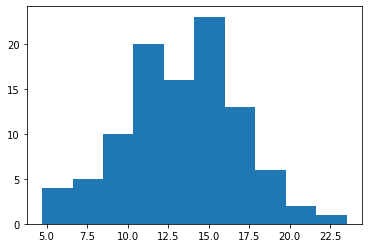

In [41]:
_ = plt.hist(loss_list)

In [42]:
def make_results(sample_list, parameter_names, injection_parameters_list=None):
    Nresult = len(sample_list)

    result_list = []
    for i in range(Nresult):
        result = bilby.gw.result.CompactBinaryCoalescenceResult()
        injection_parameters = {}
        posterior_dict = {}
        search_parameter_keys = []
        parameter_labels_with_unit = []
        for j,paraname in enumerate(parameter_names):
            '''
            if paraname=='chirp_mass':
                s = np.array(sample_list[i][j].cpu())
                s = 10**inverse_reparameterize(s, 'log10_chirp_mass')
                posterior_dict[paraname] = s
            else:
                posterior_dict[paraname] = inverse_reparameterize(np.array(sample_list[i][j].cpu()), paraname)
            '''
            posterior_dict[paraname] = inverse_reparameterize(np.array(sample_list[i][j].cpu()), paraname)
            search_parameter_keys.append(paraname)
            parameter_labels_with_unit.append(paraname)
        
        result.posterior = pd.DataFrame.from_dict(posterior_dict)
        result.injection_parameters = injection_parameters_list[i]
        
        #result.injection_parameters['chirp_mass'] = \
        #    reparameterize(torch.log10(inverse_reparameterize(result.injection_parameters['chirp_mass'], 'chirp_mass')), 'log10_chirp_mass')
        
        
        result.search_parameter_keys = search_parameter_keys
        result.parameter_labels_with_unit = parameter_labels_with_unit
        result_list.append(result)
    
    return result_list

In [43]:
#result_list = make_results(sample_list, PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY)
result_list = make_results(sample_list, parameter_names, injection_parameters_list)

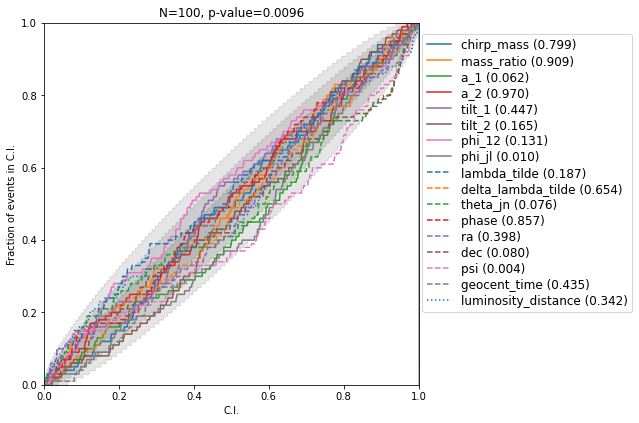

In [44]:
#fig = bilby.core.result.make_pp_plot(result_list, filename=None, save=False, confidence_interval=[0.68, 0.95, 0.997])
fig = make_pp_plot(result_list, filename = f"{config_path}/pp_plot.png", save=False, confidence_interval=[0.68, 0.95, 0.997])


In [51]:
#look_index = np.argmin(loss_list)
look_index = np.argmax(loss_list)
#look_index = 3
result = result_list[look_index]
loss_list[look_index]

tensor(23.5088)

In [52]:
result.injection_parameters

{'chirp_mass': 1.8024577635337062,
 'mass_ratio': 0.7960895596560829,
 'a_1': 0.00977794671043225,
 'a_2': 0.07952035563879917,
 'tilt_1': 2.4806258086777917,
 'tilt_2': 1.146372699253849,
 'phi_12': 3.4564907429738736,
 'phi_jl': 2.4732697079411032,
 'lambda_tilde': 3907.2921451079396,
 'delta_lambda_tilde': -427.26778850310995,
 'theta_jn': 2.2289446148927636,
 'phase': 2.6241670719388233,
 'ra': 1.465541020513665,
 'dec': -0.3373978635550861,
 'psi': 1.879530069692681,
 'geocent_time': -0.024497920857639098,
 'luminosity_distance': 197.53693475195428}

In [53]:
result.posterior

chirp_mass  mass_ratio       a_1       a_2    tilt_1    tilt_2  \
0       1.852163    0.512643  0.059026  0.060937  0.964303  1.143059   
1       2.241290    0.955570  0.018315  0.052637  1.557211  0.355783   
2       2.078841    0.769223  0.050897  0.099072  1.420478  2.127669   
3       1.451458    0.826604  0.054587  0.057696  2.804590  1.562347   
4       1.384275    0.832390  0.070165  0.059463  1.660242  2.055970   
...          ...         ...       ...       ...       ...       ...   
4995    1.504489    0.714021  0.098938  0.038468  1.496818  0.614943   
4996    2.202090    0.797961  0.052788  0.053450  2.236742  1.490081   
4997    1.686746    0.511297  0.018800  0.078645  0.112031  2.303725   
4998    1.842823    0.615769  0.015677  0.048146  2.678173  1.289156   
4999    2.179978    0.923752  0.044371  0.080884  1.917270  1.628791   

        phi_12    phi_jl  lambda_tilde  delta_lambda_tilde  theta_jn  \
0     5.468025  3.149848   3612.983887         -696.168762  0.945655   
1     1.583989  0.665032   2380.418457         -915.694336  1.797888   
2     0.618373  3.261636    752.743164          314.195984  1.448607   
3     1.834153  4.773659   2632.284668         -944.180359  1.775035   
4     3.600653  3.127885   3727.275635         -756.734497  2.263913   
...        ...       ...           ...                 ...       ...   
4995  4.640844  3.716842   3418.203857         -620.957214  1.119434   
4996  3.261913  4.742269   2434.756592         -875.711792  1.727955   
4997  4.308587  4.985823   4355.723145        -1359.889160  0.854589   
4998  3.806561  5.285342   1329.578613          311.620667  1.740022   
4999  6.252242  2.639512   1508.665527         -234.764877  1.828320   

         phase        ra       dec       psi  geocent_time  \
0     4.527284  1.377634 -0.822962  0.649599      0.062062   
1     5.414302  4.040267  0.521847  1.751498     -0.091677   
2     3.060029  5.900858 -0.641828  1.734305      0.034535   
3     4.705933  1.790899 -1.054889  3.176483     -0.096612   
4     5.240119  1.162541 -0.234544  2.296348      0.092202   
...        ...       ...       ...       ...           ...   
4995  4.951655  1.076463  0.029307  2.411175     -0.074302   
4996  5.764318  1.853810 -0.105887  0.917502     -0.004834   
4997  5.707008  2.682527 -0.368278  0.318564     -0.000049   
4998  6.224378  5.445966 -0.575409  1.607157     -0.010947   
4999  4.373727  4.386661  0.444739  2.565089     -0.044999   

      luminosity_distance  
0               43.546597  
1               32.930611  
2               41.224556  
3              170.062012  
4               98.438133  
...                   ...  
4995           146.444412  
4996           170.572845  
4997            22.085930  
4998           172.890564  
4999            79.661804  

[5000 rows x 17 columns]

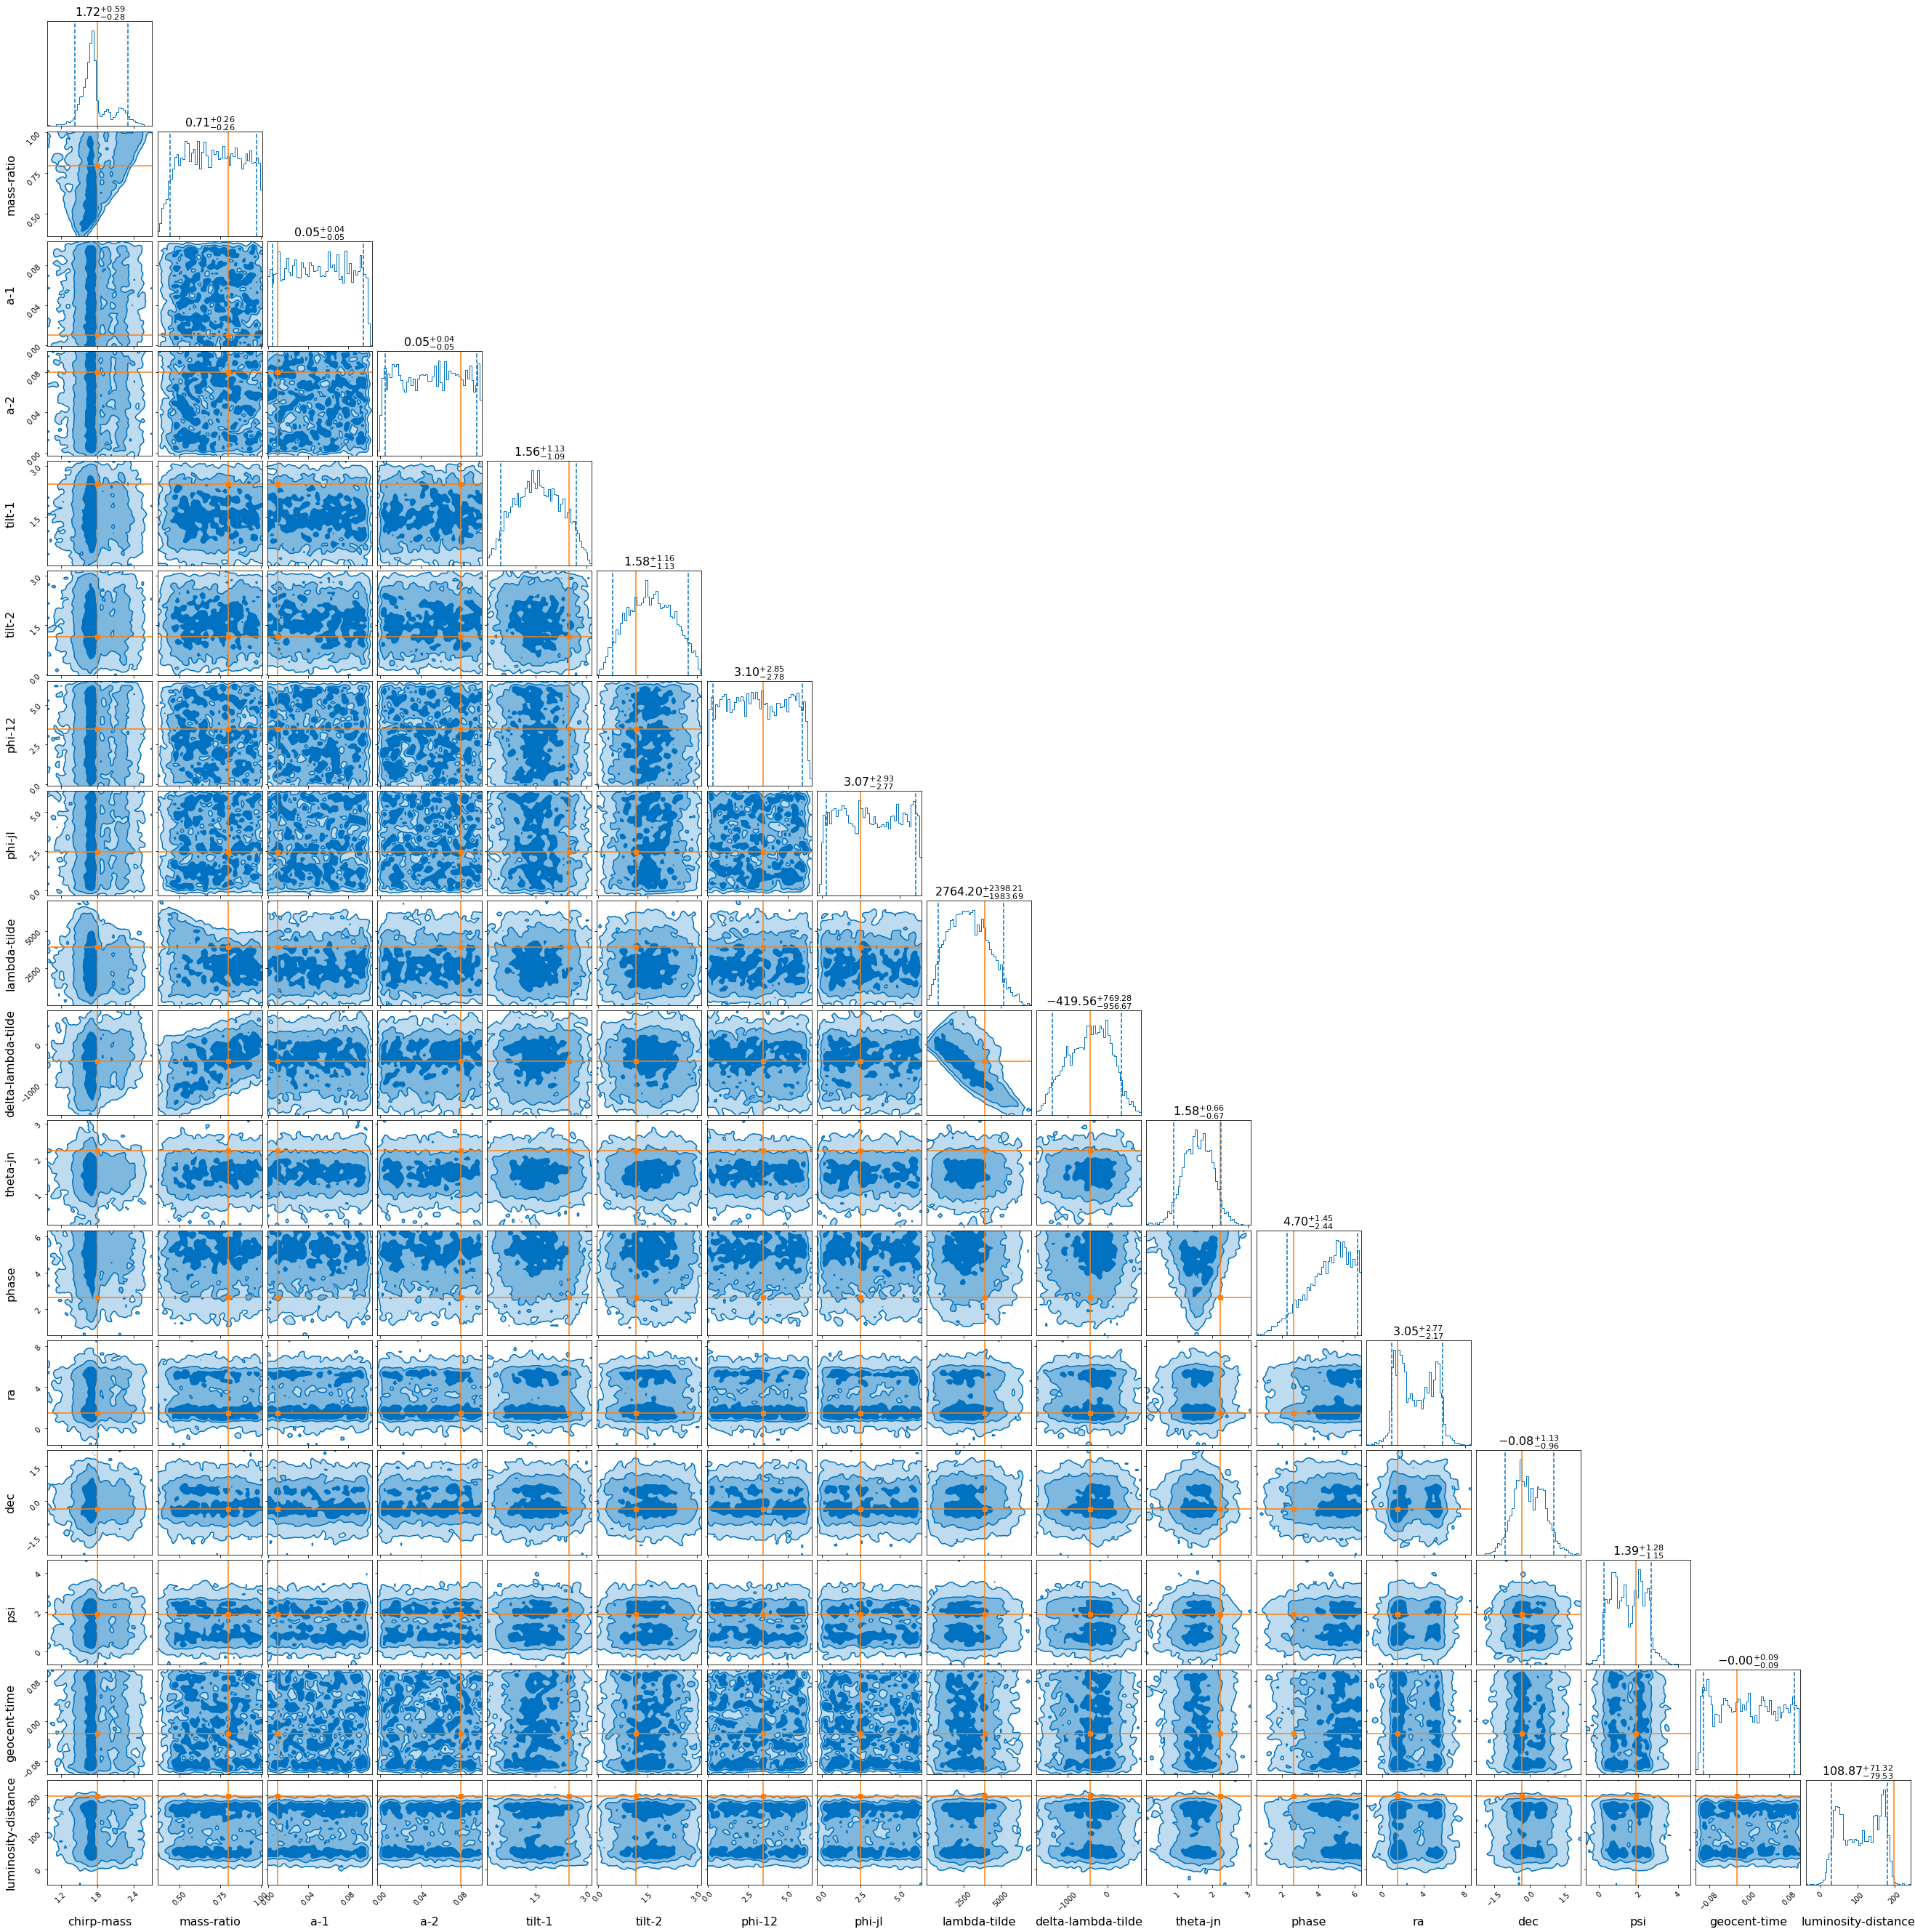

In [54]:
injdict = {}
#for i,paraname in enumerate(config_dict['data_generator_parameters']['context_parameter_names']):
for i,paraname in enumerate(parameter_names):
    injdict[paraname] = dataset_valid[0][0][i].cpu()

#result.injection_parameters = injdict
filename =  f"{config_path}/corner{look_index}.png"

plot_params = result.injection_parameters
fig = result.plot_corner(parameters=plot_params, save=False, filename = filename, quantiles=[0.05,0.95])





In [68]:
result_prior = bilby.core.result.read_in_result('/home/qian.hu/mlpe/river/scripts/outputs/prior_samples.pkl')
results = [result, result_prior]


/home/qian.hu/.conda/envs/myigwn-py39/lib/python3.9/site-packages/corner/corner.py:806: UserWarning: The following kwargs were not used by contour: 'linestyle'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)
/home/qian.hu/.conda/envs/myigwn-py39/lib/python3.9/site-packages/corner/corner.py:806: UserWarning: The following kwargs were not used by contour: 'linestyle'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)


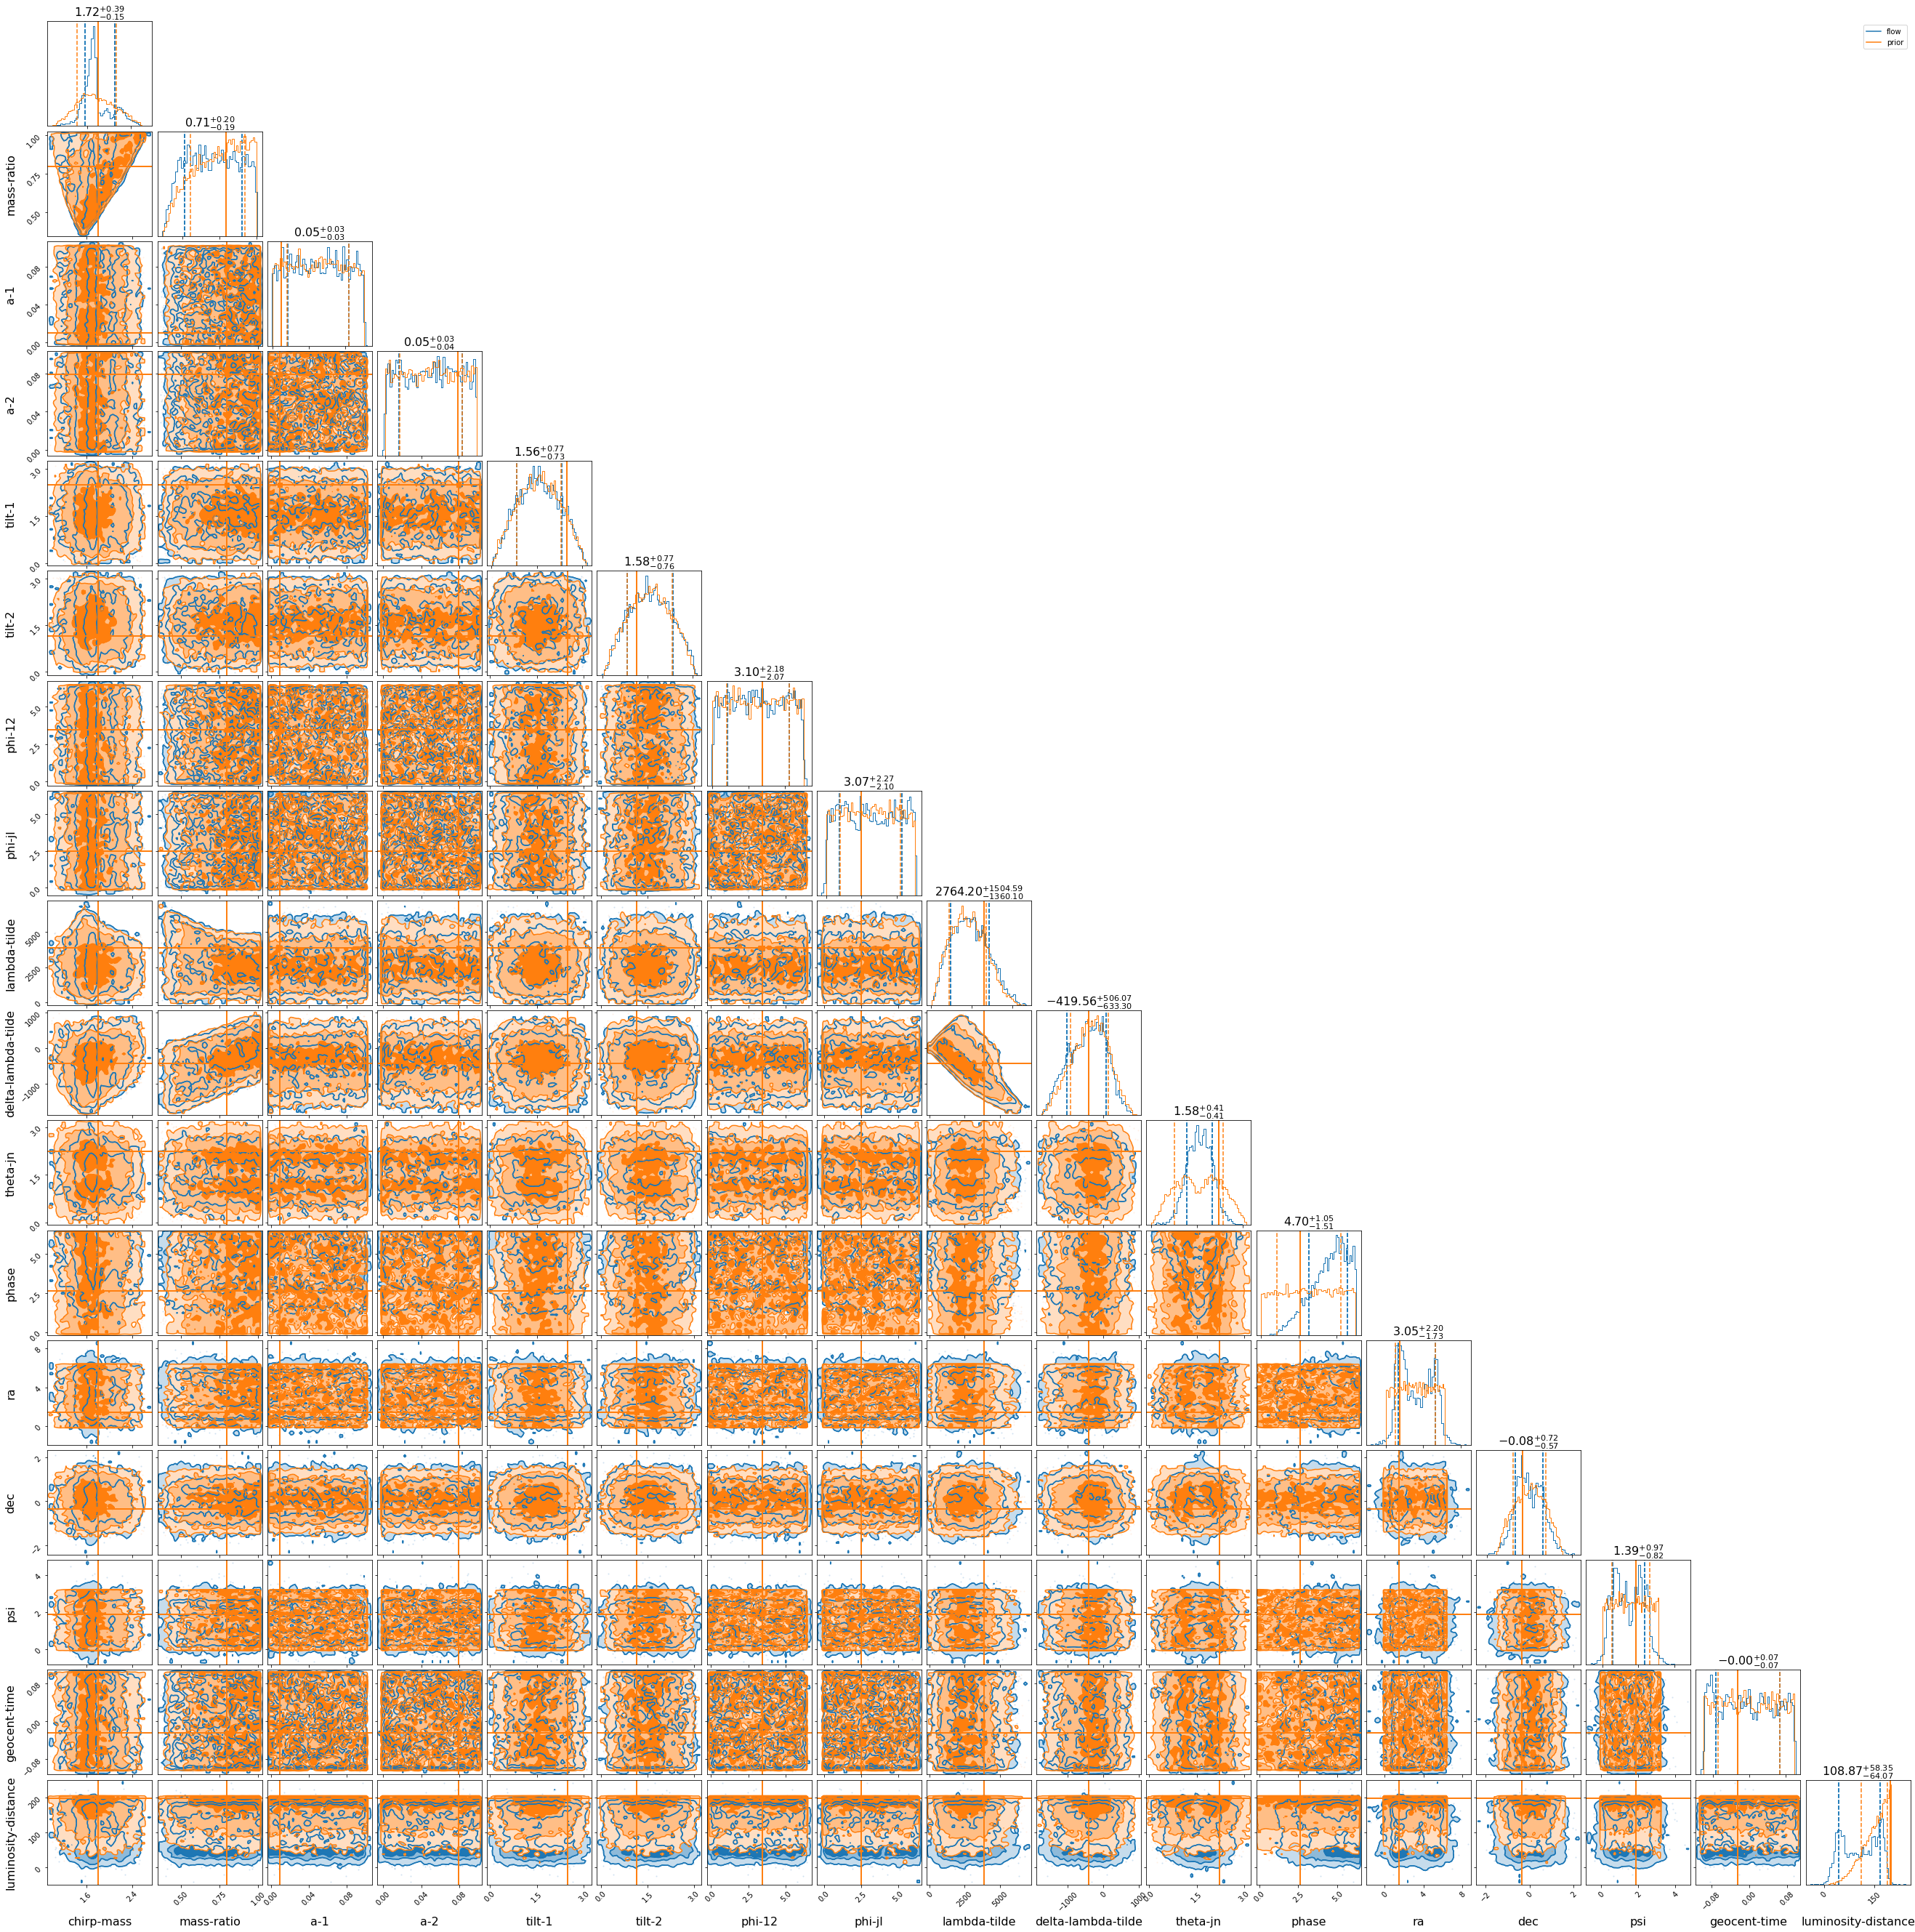

In [69]:
fig = bilby.core.result.plot_multiple(results, parameters=plot_params, filename=None, labels=['flow', 'prior'], colours=None, save=False, evidences=False, corner_labels=None, linestyles=None)

